In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, div.text_cell_render ol li p, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

# <span style="color:red">ch5_LSTM(RNN, GRU)으로 영화평 구분하기</span>
- imdb사이트의 5만개 영화 감상평 : Train/test - 타겟변수:부정/긍정

# 1. 패키지 import

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time # 유닉스time을 계산하기 위해

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import pandas as pd

# 2. 하이퍼파라미터 설정
- 하이퍼파라이터를 바꾸면 모델의 정확도나 속도에 차이남

In [10]:
MY_WORDS = 1000 # imdb 데이터 안의 단어 수
MY_LENGTH = 80   # 독립변수 차원(영화평 평균길이 정도)
MY_EMBED  = 32   # Embedding 결과 차원
MY_HIDDEN = 64   # LSTM의 units 수

MY_EPOCH = 10   # fit 반복학습수
MY_BATCH = 200 # 배치사이즈(fit할 때, 매번 가져오는 데이터 수)

# 불용어 설정(빈도수가 높은 상위 1~20은 대부분 the, a, is...)
SKIP_TOP = 20

# 3. 데이터 불러오기

In [11]:
(X_train, y_train), (X_test, y_test)=imdb.load_data(num_words=MY_WORDS, # 1~MYWORDS이외는 2로 가져옴
                                                   skip_top=SKIP_TOP # 1~20까지를 2로 가져옴
                                                   )

In [12]:
print('학습용 독립변수 모양 :', X_train.shape)
print('학습용 타겟변수 모양 :', y_train.shape)
print('학습용 독립변수 샘플 :', X_train[0][:80])
print('학습용 타겟변수(0:부정/1:긍정) 샘플 :', y_train[0])
print('테스트용 독립변수 모양 :', X_test.shape)
print('테스트용 타겟변수 모양 :', y_test.shape)

학습용 독립변수 모양 : (25000,)
학습용 타겟변수 모양 : (25000,)
학습용 독립변수 샘플 : [2, 2, 22, 2, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 2, 173, 36, 256, 2, 25, 100, 43, 838, 112, 50, 670, 2, 2, 35, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 2, 2, 2, 546, 38, 2, 447, 2, 192, 50, 2, 2, 147, 2, 2, 2, 22, 2, 2, 2, 469, 2, 22, 71, 87, 2, 2, 43, 530, 38, 76, 2, 2, 2, 2, 22, 2]
학습용 타겟변수(0:부정/1:긍정) 샘플 : 1
테스트용 독립변수 모양 : (25000,)
테스트용 타겟변수 모양 : (25000,)


In [13]:
# 부/긍정 갯수
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [26]:
# 긍정 갯수
print('학습데이터의 긍정 갯수 :', y_train.sum())
print('테스트데이터의 긍정 갯수 :', y_test.sum())

학습데이터의 긍정 갯수 : 12500
테스트데이터의 긍정 갯수 : 12500


# 4. 문자단어 -> 정수

In [29]:
word_to_id = imdb.get_word_index() # 단어(word):정수(id) (빈도가 높은 단어는 앞)
print(word_to_id['movie'])
print(word_to_id.get('film'))
print(word_to_id['the'])
# 정수 -> 문자 단어
id_to_word= {} # 정수(id) : 문자단어
for key, value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word.get(1))
# SKIP_TOP을 고민하기 위해 최빈 단어(현재 SKIP_TOP값 20)
print([id_to_word[i] for i in range(1, 48)])

17
19
1
movie
film
the
['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there']


In [32]:
msg = "What a wonderful movieabdbdsb"
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자 2: MY_WORDS(10000)이내에 들어가지 않는 단어, 3:padding처리
data = [1]+[word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoded된 내용(data)_SKIP_TOP처리 안 할 경우 :', data)
data = [d if d>20 else 2 for d in data]
print('SKIP_TOP 처리할 경우 :', data)
print('data 추정 :', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'movieabdbdsb']
원 후기 내용 : ['what', 'a', 'wonderful', 'movieabdbdsb']
encoded된 내용(data)_SKIP_TOP처리 안 할 경우 : [1, 51, 6, 389, 2]
SKIP_TOP 처리할 경우 : [2, 51, 2, 389, 2]
data 추정 : ??? what ??? wonderful ???


In [33]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', '???', 'wonderful', '???']

# 5. 숫자영화평 -> 자연어 영화평 함수

In [51]:
def decoding(review_nums):
    decoded = [] # 숫자를 단어로 해석한 내용 append
    #print(review_nums)
    for num in review_nums:
        word = id_to_word.get(num - 3, '???')
        decoded.append(word)
    print(' '.join(decoded))

In [52]:
print(X_train[0])
print(decoding(X_train[0]))

[  2   2  22   2  43 530 973   2   2  65 458   2  66   2   2 173  36 256
   2  25 100  43 838 112  50 670   2   2  35 480 284   2 150   2 172 112
 167   2 336 385  39   2 172   2   2   2 546  38   2 447   2 192  50   2
   2 147   2   2   2  22   2   2   2 469   2  22  71  87   2   2  43 530
  38  76   2   2   2   2  22   2]
??? ??? film ??? just brilliant casting ??? ??? story direction ??? really ??? ??? part they played ??? you could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same ??? ??? ??? myself so ??? loved ??? fact there ??? ??? real ??? ??? ??? film ??? ??? ??? throughout ??? film were great ??? ??? just brilliant so much ??? ??? ??? ??? film ???
None


# 6. 영화평 학습용 데이터 처음 10개의 길이 출력 함수

In [41]:
def show_length():
    print('첫 20개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이 :{len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
show_length()

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [42]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [43]:
# X_train 후기 중 가장 긴 단어수, 가장 짧은 단어수
max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

In [46]:
# 영화평 길이 평균
np.array([len(x) for x in X_train]).mean()

238.71364

# 7. 모든 영화평의 길이를 동일하게(MY_LENGTH만큼)
- post짜르기, post붙이기 : 0.7618
- pre짜르기, pre붙이기 : 0.7982
- post짜르기, pre붙이기 : 0.7993
- pre짜르기, post붙이기 : 0.7863

In [47]:
X_train = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 앞에 zero를 붙임
                     )
X_test = pad_sequences(X_test, 
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 앞에 zero를 붙임
                    )
show_length()

첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


In [48]:
X_train[0]

array([  2,   2,  22,   2,  43, 530, 973,   2,   2,  65, 458,   2,  66,
         2,   2, 173,  36, 256,   2,  25, 100,  43, 838, 112,  50, 670,
         2,   2,  35, 480, 284,   2, 150,   2, 172, 112, 167,   2, 336,
       385,  39,   2, 172,   2,   2,   2, 546,  38,   2, 447,   2, 192,
        50,   2,   2, 147,   2,   2,   2,  22,   2,   2,   2, 469,   2,
        22,  71,  87,   2,   2,  43, 530,  38,  76,   2,   2,   2,   2,
        22,   2])

# 8. 최종 데이터 shape 확인

In [49]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

In [50]:
decoding(X_train[0])

??? ??? film ??? just brilliant casting ??? ??? story direction ??? really ??? ??? part they played ??? you could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same ??? ??? ??? myself so ??? loved ??? fact there ??? ??? real ??? ??? ??? film ??? ??? ??? throughout ??? film were great ??? ??? just brilliant so much ??? ??? ??? ??? film ???


# 9. 모델 생성 및 구현

In [60]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,  # 10000
                    output_dim=MY_EMBED, # 32
                    input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
               dropout=0.4, #0.1~0.5 각 스텝마다 LSTM셀로 들어가는 연결 30% 0으로
               recurrent_dropout=0.3, # 0.1~0.3 이전 LSTM에서 다음 LSTM셀로 가는 연결 20% 0으로
              #input_shape=(MY_LENGTH, MY_EMBED),
              # kernel_initializer='he_normal' , #입력 가중치 초기화
              # recurrent_initializer= 'orthogonal' # 순환 가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 80, 32)            32000     
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 56,897
Trainable params: 56,897
Non-trainable params: 0
_________________________________________________________________


# 10. 학습환경 설정 및 학습하기

In [61]:
model.compile(loss='binary_crossentropy', # 이중분류(로지스틱회귀분석)
              optimizer='adam',
              metrics=['acc']
             )
start = time() # 70.1.1 ~ 이 시점까지 초수
hist = model.fit(X_train, y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1)
end = time() # 70.1.1 ~ 이 시점까지 초수
print('총 fit 시간 : {:.5f}'.format(end-start))

Epoch 1/10
100/100 [==============================] - 14s 128ms/step - loss: 0.6409 - acc: 0.6083 - val_loss: 0.5171 - val_acc: 0.7534
Epoch 2/10
100/100 [==============================] - 12s 123ms/step - loss: 0.4966 - acc: 0.7631 - val_loss: 0.4699 - val_acc: 0.7776
Epoch 3/10
100/100 [==============================] - 12s 123ms/step - loss: 0.4654 - acc: 0.7819 - val_loss: 0.4633 - val_acc: 0.7772
Epoch 4/10
100/100 [==============================] - 12s 123ms/step - loss: 0.4581 - acc: 0.7851 - val_loss: 0.4670 - val_acc: 0.7762
Epoch 5/10
100/100 [==============================] - 12s 125ms/step - loss: 0.4532 - acc: 0.7879 - val_loss: 0.4680 - val_acc: 0.7778
Epoch 6/10
100/100 [==============================] - 12s 124ms/step - loss: 0.4433 - acc: 0.7915 - val_loss: 0.4656 - val_acc: 0.7818
Epoch 7/10
100/100 [==============================] - 12s 124ms/step - loss: 0.4461 - acc: 0.7897 - val_loss: 0.4643 - val_acc: 0.7812
Epoch 8/10
100/100 [==============================] - 1

# 11. 모델평가

In [83]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

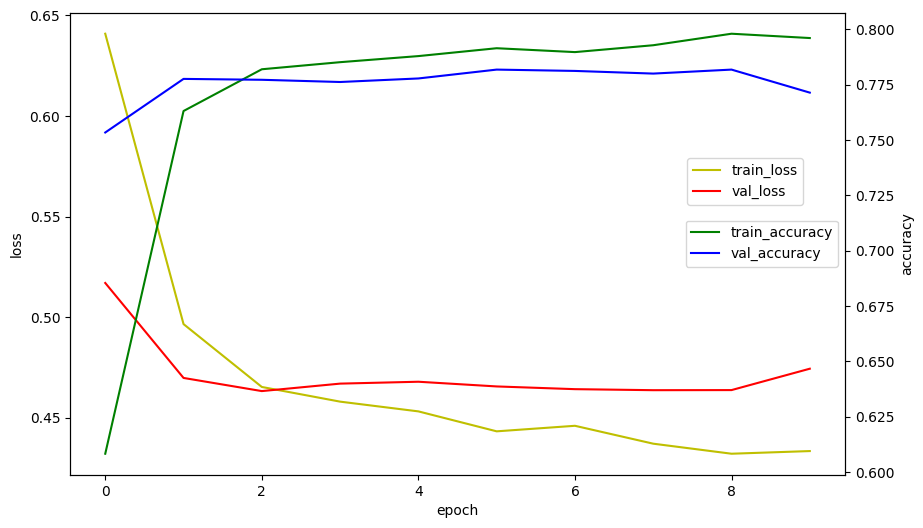

In [62]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [113]:
# 테스트 데이터로 평가
loss, acc = model.evaluate(X_test, y_test)
print('test의 데이터 정확도 :', acc)

782/782 [==============================] - 7s 9ms/step - loss: 0.4741 - acc: 0.7751
test의 데이터 정확도 : 0.7751200199127197
